In [1]:
import numpy as np
from scipy.optimize import line_search


def newton_method_with_line_search(f, grad_f, hess_f, x0, max_iter=1000, tol=1e-6,
                                   c1=1e-4, c2=0.9, max_line_search=20):
    x = x0.copy()
    trajectory = [x.copy()]
    f_values = [f(x)]

    for i in range(max_iter):
        gradient = grad_f(x)
        hessian = hess_f(x)

        if np.linalg.norm(gradient) < tol:
            break

        try:
            direction = -np.linalg.solve(hessian, gradient)
        except np.linalg.LinAlgError:
            direction = -gradient

        alpha, _, _, _, _, _ = line_search(f, grad_f, x, direction,
                                           gfk=gradient,
                                           old_fval=f(x),
                                           c1=c1, c2=c2,
                                           maxiter=max_line_search)

        if alpha is None:
            alpha = 1.0

        x = x + alpha * direction
        trajectory.append(x.copy())
        f_values.append(f(x))

    return x, np.array(trajectory), np.array(f_values)

In [2]:
from scipy.optimize import minimize


def optimize_with_scipy(f, grad_f, hess_f, x0, method='Newton-CG', max_iter=1000, tol=1e-6):
    trajectory = [x0.copy()]
    f_values = [f(x0)]

    def callback(xk):
        trajectory.append(xk.copy())
        f_values.append(f(xk))

    options = {'maxiter': max_iter, 'disp': False}

    if method == 'Newton-CG':
        res = minimize(f, x0, method='Newton-CG', jac=grad_f, hess=hess_f,
                       options=options, tol=tol, callback=callback)
    elif method == 'BFGS':
        res = minimize(f, x0, method='BFGS', jac=grad_f,
                       options=options, tol=tol, callback=callback)
    elif method == 'L-BFGS-B':
        res = minimize(f, x0, method='L-BFGS-B', jac=grad_f,
                       options=options, tol=tol, callback=callback)
    else:
        raise ValueError(f"Unknown method: {method}")

    return res.x, np.array(trajectory), np.array(f_values)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm


def plot_optimization_paths(f, results, x_limits, y_limits, levels=20):
    plt.figure(figsize=(10, 8))

    # Создаем сетку для линий уровня
    x = np.linspace(x_limits[0], x_limits[1], 100)
    y = np.linspace(y_limits[0], y_limits[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

    # Рисуем линии уровня
    cs = plt.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.5)
    plt.clabel(cs, inline=True, fontsize=8)

    for i, (method, result) in enumerate(results.items()):
        path = result[1]
        plt.plot(path[:, 0], path[:, 1],
                 label=f"{method} (start: [{result[1][0, 0]:.1f}, {result[1][0, 1]:.1f}])")

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Траектории оптимизации с линиями уровня')
    plt.legend()
    plt.grid(True)
    plt.show()

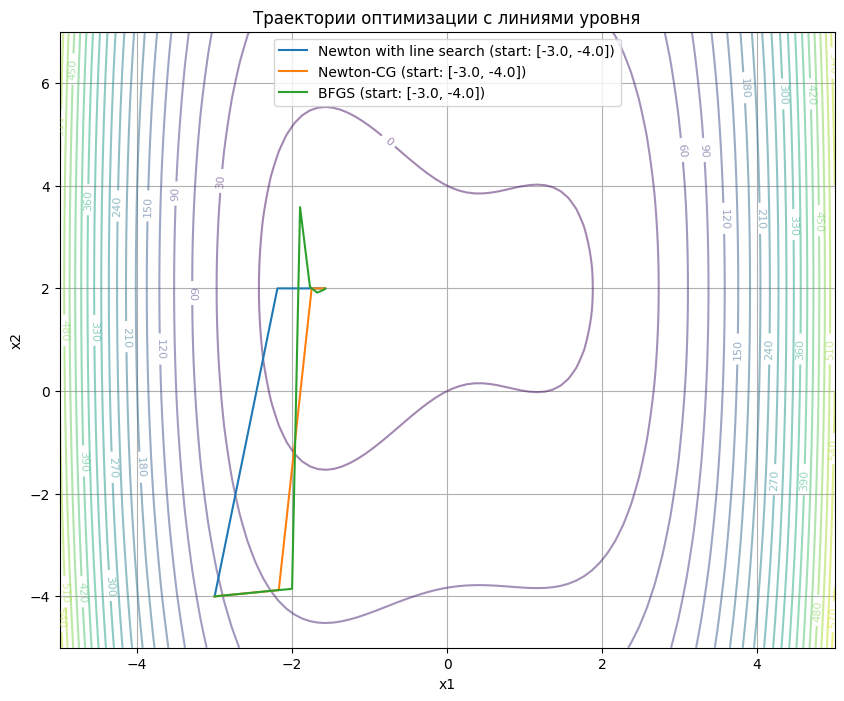

In [4]:
def f(x):
    return x[0] ** 4 - 4 * x[0] ** 2 + x[1] ** 2 + 3 * x[0] - 4 * x[1]


def f_grad(x):
    return np.array([4 * x[0] ** 3 - 8 * x[0] + 3, 2 * x[1] - 4])


def f_hess(x):
    return np.array([[12 * x[0] ** 2 - 8, 0], [0, 2]])


x0 = np.array([-3.0, -4.0])

methods = {
    'Newton with line search': newton_method_with_line_search(f, f_grad, f_hess, x0),
    'Newton-CG': optimize_with_scipy(f, f_grad, f_hess, x0, method='Newton-CG'),
    'BFGS': optimize_with_scipy(f, f_grad, f_hess, x0, method='BFGS')
}

plot_optimization_paths(f, methods, x_limits=(-5, 5), y_limits=(-5, 7))

In [5]:
def bfgs_method(f, grad_f, hess_f, x0, max_iter=1000, tol=1e-6, c1=1e-4, c2=0.9,
                max_line_search=20, epsilon=1e-8):
    x = x0.copy()
    n = len(x)
    trajectory = [x.copy()]
    f_values = [f(x)]

    H_k = np.eye(n)
    grad_k = grad_f(x)

    for k in range(max_iter):
        if np.linalg.norm(grad_k) < tol:
            break
        p_k = -H_k @ grad_k
        alpha_k, _, _, _, _, _ = line_search(f, grad_f, x, p_k,
                                             gfk=grad_k,
                                             old_fval=f(x),
                                             c1=c1, c2=c2,
                                             maxiter=max_line_search)
        if alpha_k is None:
            alpha_k = 1.0

        x_new = x + alpha_k * p_k
        grad_new = grad_f(x_new)
        s_k = x_new - x
        y_k = grad_new - grad_k

        rho_k = 1.0 / (y_k.T @ s_k)

        term1 = np.eye(n) - rho_k * np.outer(s_k, y_k)
        term2 = np.eye(n) - rho_k * np.outer(y_k, s_k)
        term3 = rho_k * np.outer(s_k, s_k)

        H_k = term1 @ H_k @ term2 + term3

        x = x_new
        grad_k = grad_new
        trajectory.append(x.copy())
        f_values.append(f(x))

    return x, np.array(trajectory), np.array(f_values)

In [6]:
import time
from collections import defaultdict


def compare_methods(f, grad_f, hess_f, x0, methods):
    results = {}
    stats = defaultdict(dict)

    for name, method in methods.items():
        start_time = time.time()
        results[name] = method(f, grad_f, hess_f, x0)
        elapsed_time = time.time() - start_time

        stats[name]['time'] = elapsed_time
        stats[name]['iterations'] = len(results[name][2]) - 1
        stats[name]['final_value'] = f(results[name][0])

    return results, stats


def rosenbrock(x):
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2


def rosenbrock_grad(x):
    return np.array([-400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0]),
                     200 * (x[1] - x[0] ** 2)])


def rosenbrock_hess(x):
    return np.array([[1200 * x[0] ** 2 - 400 * x[1] + 2, -400 * x[0]],
                     [-400 * x[0], 200]])


methods = {
    'Newton': newton_method_with_line_search,
    'BFGS': bfgs_method,
    'Newton-CG': lambda f, g, h, x0: optimize_with_scipy(f, g, h, x0, 'Newton-CG'),
    'L-BFGS-B': lambda f, g, h, x0: optimize_with_scipy(f, g, h, x0, 'L-BFGS-B')
}

x0 = np.array([-1.5, 2.0])

results, stats = compare_methods(rosenbrock, rosenbrock_grad, rosenbrock_hess, x0, methods)

print("{:<15} {:<15} {:<15} {:<15}".format("Method", "Time (s)", "Iterations", "Final value"))
for name in methods:
    print("{:<15} {:<15.4f} {:<15} {:<15.6f}".format(
        name, stats[name]['time'], stats[name]['iterations'], stats[name]['final_value']))

Method          Time (s)        Iterations      Final value    
Newton          0.0014          23              0.000000       
BFGS            0.0029          37              0.000000       
Newton-CG       0.0203          191             0.000000       
L-BFGS-B        0.0034          42              0.000000       


In [7]:
import optuna

def objective_f(trial):
    max_iter = trial.suggest_int('max_iter', 50, 500)
    tol = trial.suggest_loguniform('tol', 1e-8, 1e-4)
    c1 = trial.suggest_loguniform('c1', 1e-6, 1e-2)
    c2 = trial.suggest_loguniform('c2', 0.1, 0.999)

    x0 = np.array([10.0, 10.0])

    result = newton_method_with_line_search(f, f_grad, f_hess,
                                            x0=x0, max_iter=max_iter, tol=tol,
                                            c1=c1, c2=c2)

    return f(result[0])

study_quadratic = optuna.create_study(direction='minimize')
study_quadratic.optimize(objective_f, n_trials=50)

print("Лучшие параметры для квадратичной функции:")
print(study_quadratic.best_params)

/Users/danyarmarkin/ITMO/MetodsOfOptimisation/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-05 15:59:06,479] A new study created in memory with name: no-name-66607382-1e77-4500-bec0-f36f7c81c262
/var/folders/f2/pvrqnw9x161cmlnd2jk6v4x40000gn/T/ipykernel_25330/1445367919.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-8, 1e-4)
/var/folders/f2/pvrqnw9x161cmlnd2jk6v4x40000gn/T/ipykernel_25330/1445367919.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Лучшие параметры для квадратичной функции:
{'max_iter': 337, 'tol': 3.3786862503145984e-06, 'c1': 3.588982654821861e-06, 'c2': 0.3140630738927041}


In [8]:
def objective_rosenbrock(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_loguniform('tol', 1e-8, 1e-4)
    c1 = trial.suggest_loguniform('c1', 1e-6, 1e-2)
    c2 = trial.suggest_loguniform('c2', 0.1, 0.999)
    epsilon = trial.suggest_loguniform('epsilon', 1e-10, 1e-6)

    x0 = np.array([-1.5, 2.0])

    result = bfgs_method(rosenbrock, rosenbrock_grad, None,
                           x0=x0, max_iter=max_iter, tol=tol,
                           c1=c1, c2=c2, epsilon=epsilon)

    return rosenbrock(result[0])

study_rosenbrock = optuna.create_study(direction='minimize')
study_rosenbrock.optimize(objective_rosenbrock, n_trials=50)

print("\nЛучшие параметры для функции Розенброка:")
print(study_rosenbrock.best_params)

[I 2025-06-05 15:59:07,089] A new study created in memory with name: no-name-3d34b5b9-9210-42b1-882c-c7cfaff623dc
/var/folders/f2/pvrqnw9x161cmlnd2jk6v4x40000gn/T/ipykernel_25330/4000270020.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-8, 1e-4)
/var/folders/f2/pvrqnw9x161cmlnd2jk6v4x40000gn/T/ipykernel_25330/4000270020.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c1 = trial.suggest_loguniform('c1', 1e-6, 1e-2)
/var/folders/f2/pvrqnw9x161cmlnd2jk6v4x40000gn/T/ipykernel_25330/4000270020.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/


Лучшие параметры для функции Розенброка:
{'max_iter': 441, 'tol': 1.1910636518050363e-08, 'c1': 0.003233283617063259, 'c2': 0.10146412947959704, 'epsilon': 6.051425368459169e-10}


In [9]:
# Визуализация для квадратичной функции
optuna.visualization.plot_optimization_history(study_quadratic).show()
optuna.visualization.plot_slice(study_quadratic).show()

# Визуализация для функции Розенброка
optuna.visualization.plot_optimization_history(study_rosenbrock).show()
optuna.visualization.plot_slice(study_rosenbrock).show()